In [1]:
from virusPropagationModel import *
%matplotlib inline
import glob
import os
 

In [2]:
modeledWorld1 = ModeledPopulatedWorld(1000,10, world_from_file=True, geofile_name='datafiles/Buildings_Gangelt_MA_3.csv', agent_agent_infection=True)
print('Number of agents: '+ str(modeledWorld1.number_of_people))
print('Distribution of initialized locations: ' + str(modeledWorld1.get_distribution_of_location_types()))

Number of agents: 1465
Distribution of initialized locations: {'hospital': 1, 'morgue': 1, 'work': 52, 'public': 11, 'school': 2, 'home': 496}


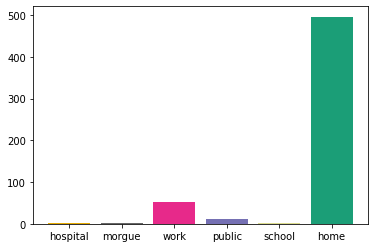

In [3]:
modeledWorld1.plot_distribution_of_location_types()

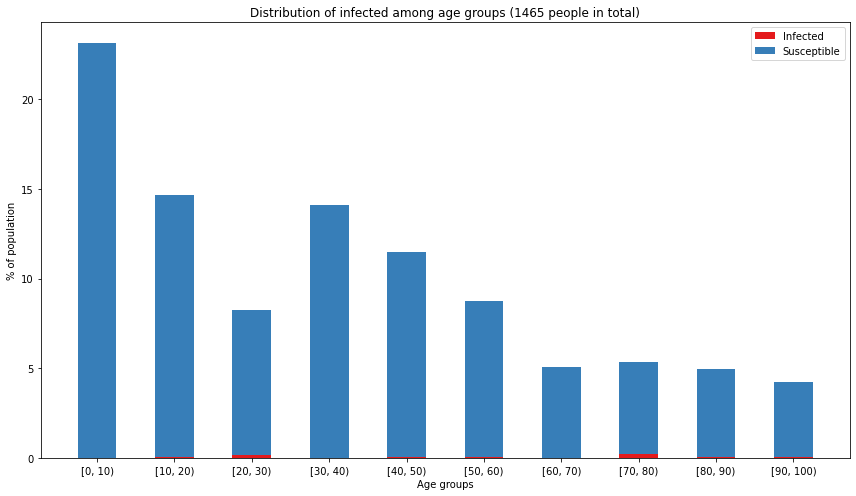

In [4]:
modeledWorld1.plot_initial_distribution_of_ages_and_infected(age_groups_step=10)

In [5]:
simulation1 = Simulation(modeledWorld1,720,run_immediately=False)
simulation1.change_agent_attributes({'all':{'behaviour_as_infected':{'value':0.5,'type':'replacement'}}})

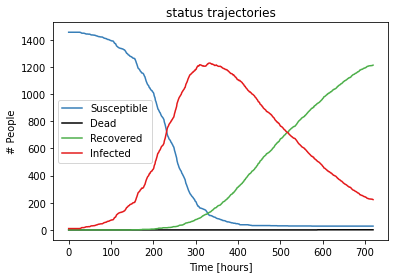

In [6]:
simulation1.simulate()
simulation1.plot_status_timecourse()

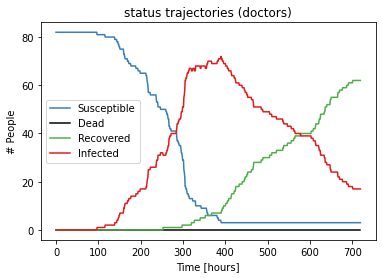

In [7]:
simulation1.plot_status_timecourse(specific_people='doctors')

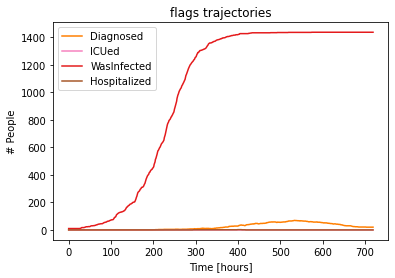

In [8]:
simulation1.plot_flags_timecourse()

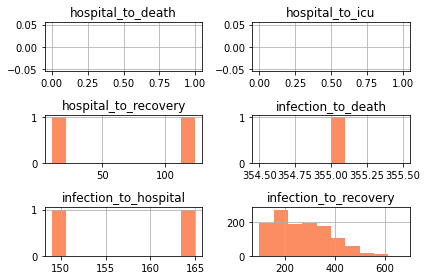

In [9]:
simulation1.plot_distributions_of_durations()

In [10]:
#simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.

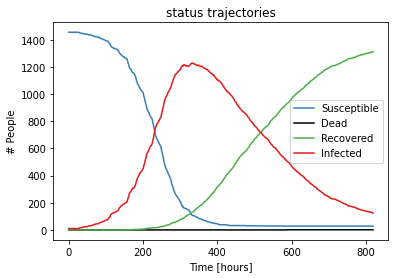

In [11]:
simulation2 = Simulation(simulation1,100) # Now Simulation class objects can be used for subsequent simulation (nested)
simulation2.plot_status_timecourse()

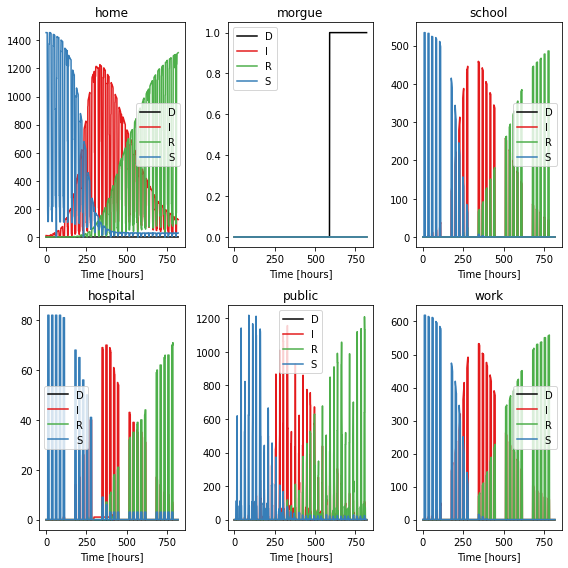

In [12]:
simulation2.plot_status_at_location()


In [13]:
#now we can save and load worlds and simulations (exported to the folder saved_objects)
#modeledWorld1.save('testingmyfirstworld')
#loadedWorld1 = load_simulation_object('testingmyfirstworld')
#simulationFromLoadedWorld1 = Simulation(loadedWorld1,100)
#simulationFromLoadedWorld1.save('testingmyfirstsimulation')
#loadedSimulation = load_simulation_object('testingmyfirstsimulation')
#loadedSimulation.plot_status_timecourse()

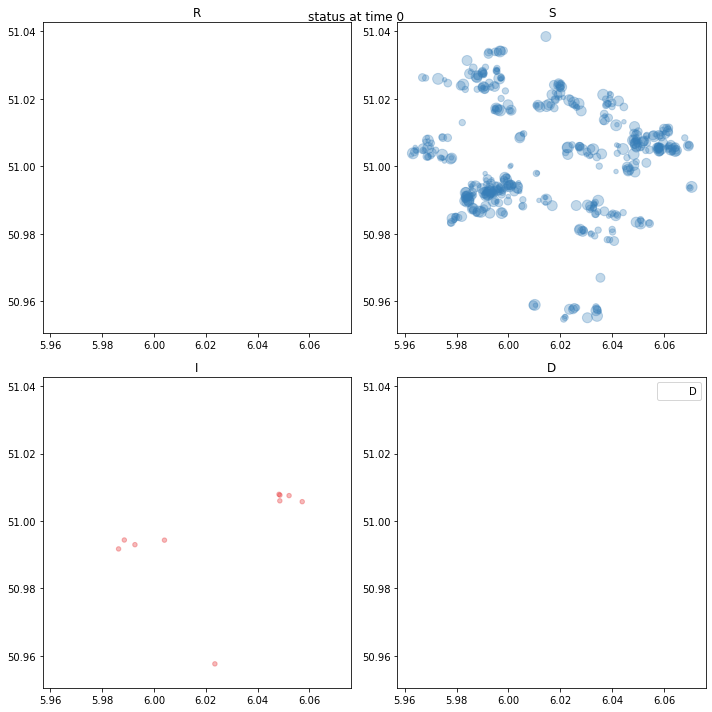

In [14]:
simulation1.map_status_at_loc(save_figure=False,time_steps=1)

In [15]:
# removes files saved in the cells in this notebook
for file in glob.glob("*/testing*"):
    os.remove(file)

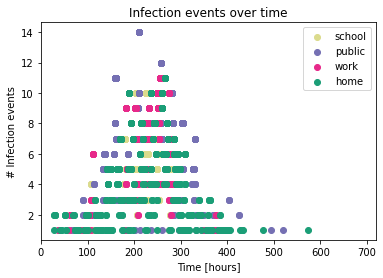

In [16]:
simulation1.plot_infections_per_location_type_over_time()

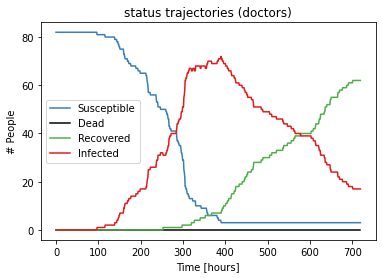

In [17]:
simulation1.plot_status_timecourse(specific_people='doctors')

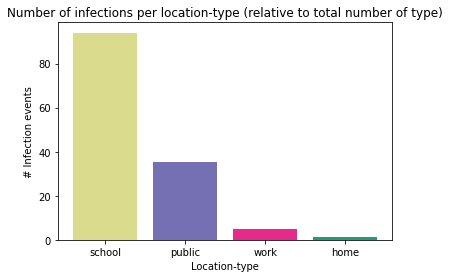

In [18]:
simulation1.plot_infections_per_location_type()